#  Foundational Setup and Environment Initialization

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", map_name="4x4")
env.action_space.seed(42)  # Set seed for reproducibility

state_size = env.observation_space.n # (16 states: 0 to 15)
action_size = env.action_space.n

print(f"Environment: FrozenLake-v1 (4x4, Non-Slippery)")
print(f"State space size: {state_size} (0 to 15)")
print(f"Action space size: {action_size} (0=L, 1=D, 2=R, 3=U)")

Environment: FrozenLake-v1 (4x4, Non-Slippery)
State space size: 16 (0 to 15)
Action space size: 4 (0=L, 1=D, 2=R, 3=U)


# Q-Learning Theory and the Q-Table

In [ ]:
#Initialize Q-table with zeros

Qtable = np.zeros((state_size, action_size))

print("Q-table initialized successfully with dimensions (States x Actions):", Qtable.shape)

Q-table initialized successfully with dimensions (States x Actions): (16, 4)


# Hyperparameters and Policy Strategy

In [ ]:
# 3.1. Defining Hyperparameters
total_episodes = 10000
max_steps_per_episode = 100

#earning rate (alpha)
learning_rate = 0.7

#discount factor (gamma)
gamma = 0.95

# Epsilon-Greedy Strategy Parameters
epsilon = 0.9

#minimum epsilon
min_epsilon = 0.05

#epsilon decay rate
epsilon_decay_rate = 0.05

# Dictionary for easy parameter passing
params = {
    'total_episodes': total_episodes,
    'max_steps_per_episode': max_steps_per_episode,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'epsilon': epsilon,
    'min_epsilon': min_epsilon,
    'epsilon_decay_rate': epsilon_decay_rate
}

print("Hyperparameters configured successfully")

Hyperparameters configured successfully


In [ ]:
def choose_action(Qtable, state, epsilon, action_size):
    """
    Chooses an action based on the epsilon-greedy strategy.
    Implements random tie-breaking during exploitation.
    """
    # Exploration
    if np.random.random() < epsilon:
        # random action for exploration
        action = np.random.choice([i for i in range(0 , action_size)])
    # Exploitation: Use the Q-table to find the best action (handle ties randomly)
    else:
        #maximum Q-value for the current state
        max_q = np.max(Qtable[state, :])

        #Find all action indices that have this maximum Q-value
        optimal_actions_indices = np.where(Qtable[state, :] == max_q)

        #Randomly select one action from the optimal actions
        action = np.random.choice(optimal_actions_indices[0])

    return action

print("Epsilon-greedy action selection function defined")

Epsilon-greedy action selection function defined


# Training the Q-Learning Agent

## The Training Function
The core Q-Learning algorithm iterates over thousands of episodes, repeating four fundamental steps:Action Selection: Use the $\epsilon$-greedy strategy to choose an action $a$.Interaction: Execute $a$, observe the resulting state $s'$, the reward $R$, and whether the episode is terminated (done).Update: Apply the Bellman equation to update $Q(s, a)$.Transition: Set the current state $s$ to $s'$ and repeat until termination.

In [ ]:
def train_agent(env, Qtable_init, params):
    """
    Trains the Q-Learning agent on the environment.
    """
    Qtable = Qtable_init.copy()
    rewards_per_episode = []
    steps_per_episode = []

    epsilon = params['epsilon']
    epsilon_decay_rate = params['epsilon_decay_rate']

    for episode in range(params['total_episodes']):
        # Reset environment for a new episode
        state, info = env.reset()
        terminated = False
        truncated = False
        rewards_current_episode = 0
        steps = 0

        while not terminated and not truncated and steps < params['max_steps_per_episode']:

            action = choose_action(Qtable, state, epsilon, env.action_space.n)

            new_state, reward, terminated, truncated, info = env.step(action)

            max_future_q = np.max(Qtable[new_state : ])

            td_target = reward + gamma * max_future_q

            td_error = td_target - Qtable[state][action]

            Qtable[state][action] += learning_rate * td_error

            state = new_state
            rewards_current_episode += reward
            steps += 1

        epsilon -= (episode // (1/epsilon_decay_rate))
        epsilon = max(epsilon , min_epsilon)

        rewards_per_episode.append(rewards_current_episode)
        steps_per_episode.append(steps)

        if (episode + 1) % 1000 == 0:
             print(f"Episode {episode + 1}/{params['total_episodes']} completed. Epsilon: {round(epsilon, 4)}")

    return Qtable, rewards_per_episode, steps_per_episode

print("Training function defined successfully")

Training function defined successfully


##Executing Training and Post-Processing Metrics
Training is executed using the baseline parameters defined in Section 3.1. The historical data (rewards and steps) is then converted into a Pandas DataFrame, including a calculation of the cumulative rewards, which is highly effective for visualizing overall learning progress.   

In [ ]:
# Executing Training and Post-Processing Metrics

print("Starting training...")
Qtable_trained, rewards_history, steps_history = train_agent(env, Qtable, params)
print("Training complete.")
env.close()

# Convert history to DataFrames for analysis
results_df = pd.DataFrame({
    'Episodes': range(total_episodes),
    'Rewards': rewards_history,
    'Steps': steps_history
})

results_df['Cum_Rewards'] = results_df['Rewards'].cumsum()

results_df['Steps_Smooth'] = results_df['Steps'].rolling(window = 50, min_periods = 1).mean()

print("\nFirst 5 rows of Results DataFrame:")
print(results_df.head())
print("\nLast 5 rows of Results DataFrame:")
print(results_df.tail())

Starting training...
Episode 1000/10000 completed. Epsilon: 0.05
Episode 2000/10000 completed. Epsilon: 0.05
Episode 3000/10000 completed. Epsilon: 0.05
Episode 4000/10000 completed. Epsilon: 0.05
Episode 5000/10000 completed. Epsilon: 0.05
Episode 6000/10000 completed. Epsilon: 0.05
Episode 7000/10000 completed. Epsilon: 0.05
Episode 8000/10000 completed. Epsilon: 0.05
Episode 9000/10000 completed. Epsilon: 0.05
Episode 10000/10000 completed. Epsilon: 0.05
Training complete.

First 5 rows of Results DataFrame:
   Episodes  Rewards  Steps  Cum_Rewards  Steps_Smooth
0         0        0     33            0         33.00
1         1        0      3            0         18.00
2         2        0      3            0         13.00
3         3        0      2            0         10.25
4         4        0      7            0          9.60

Last 5 rows of Results DataFrame:
      Episodes  Rewards  Steps  Cum_Rewards  Steps_Smooth
9995      9995        0      3            1          6.30
99

#  Policy Visualization and Assessment

## 5.1. Visualization Functions
The following functions are necessary to transform the numerical results into interpretable plots. The policy mapping helper converts the 16x4 Q-table into a 4x4 grid of directional arrows (←, ↓, →, ↑).   



In [ ]:
# 5.1. Visualization Functions

# Policy Mapping Helper Function
def qtable_directions_map(qtable, map_size):
    """
    Converts the Q-table into a grid of maximum Q-values and corresponding optimal directions.
    """
    # Map action indices to Unicode arrows
    action_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}

    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)

    qtable_directions = np.array([action_map[i] for i in np.argmax(qtable, axis=1)]).reshape(map_size, map_size)

    return qtable_val_max, qtable_directions

In [ ]:
# Plotting Steps and Rewards (Learning Curves)
def plot_learning_curves(df):
    """Plots the cumulative rewards and averaged steps over episodes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ax[0].plot(df["Episodes"], df["Cum_Rewards"])
    ax[0].set_title("Cumulative Rewards Over Episodes")
    ax[0].set_xlabel("Episodes")
    ax[0].set_ylabel("Cumulative Rewards (Success Rate)")
    ax[0].grid(True, alpha=0.3)

    ax[1].plot(df["Episodes"], df["Steps_Smooth"])
    ax[1].set_title("Averaged Steps per Episode (Lower is Better)")
    ax[1].set_xlabel("Episodes")
    ax[1].set_ylabel("Steps (Smoothed)")
    ax[1].grid(True, alpha=0.3)

    fig.tight_layout()
    plt.show()

In [ ]:
# Plotting Learned Policy (Heatmap)
def plot_q_values_map(qtable, map_size):
    """
    Visualizes the final learned Q-table as a heatmap showing optimal actions.
    """
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,  # Overlay directional arrows
        fmt="",
        cmap=sns.color_palette("Blues", as_cmap=True),  # Dark blue = higher expected reward
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values and Optimal Policy (Arrows = Best Action)")
    plt.show()

print("Visualization functions defined successfully")

Visualization functions defined successfully


## 5.2. Visualization Execution and Analysis
The plots are generated using the trained Q-table and the accumulated metrics.

Generating visualizations...


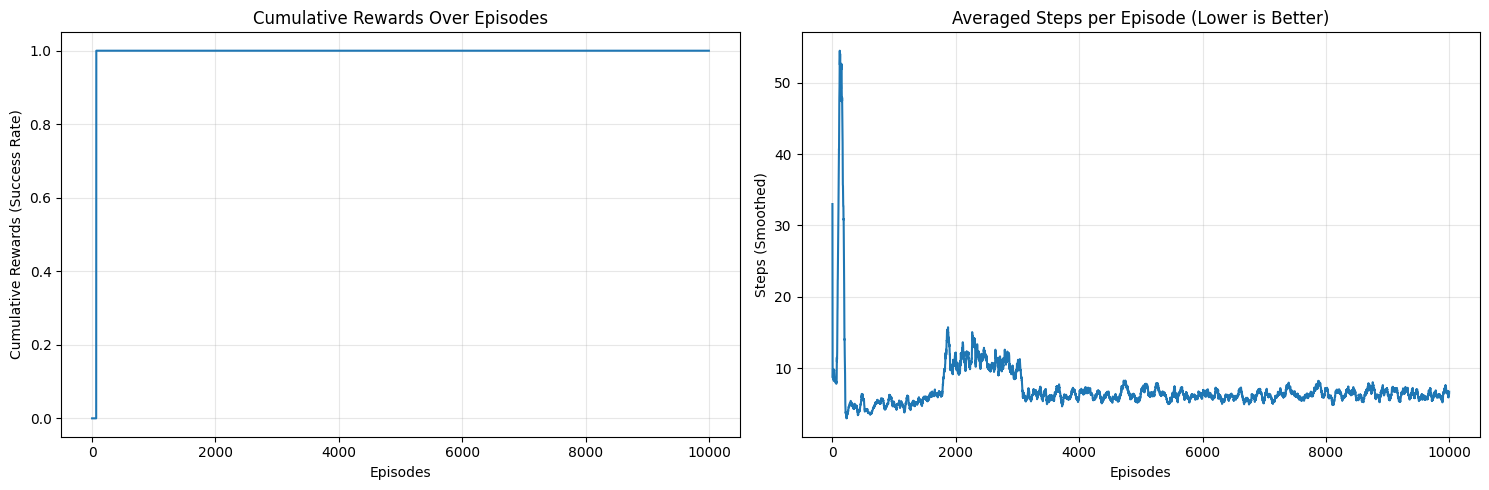

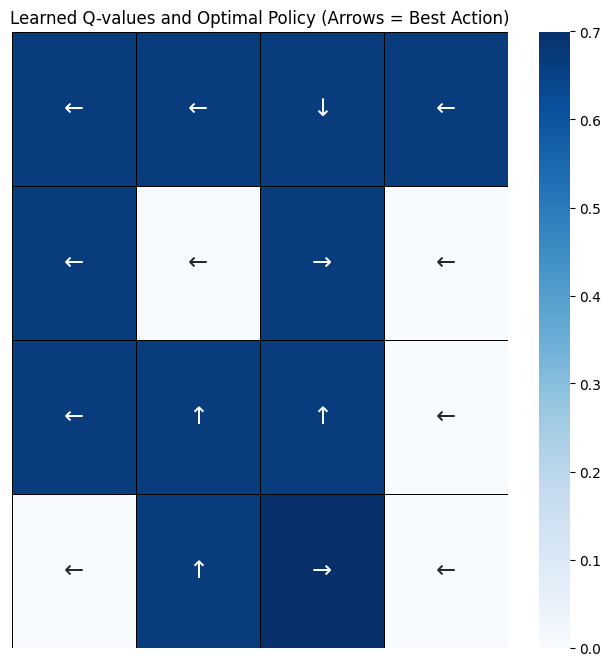

Visualizations complete!


In [ ]:
# 5.2. Visualization Execution and Analysis

print("Generating visualizations...")
plot_learning_curves(results_df)
plot_q_values_map(Qtable_trained, map_size=4)
print("Visualizations complete!")

# Hyperparameter Sensitivity Analysis
The selection of hyperparameters significantly influences the efficiency and stability of learning. We analyze the effects of the Learning Rate ($\alpha$) and the Discount Factor ($\gamma$) by comparing contrasting values on the deterministic environment.

## Case Study A: The Impact of Learning Rate ($\alpha$)


--- Experiment 1: Low Alpha (Slow Update) ---
Episode 1000/10000 completed. Epsilon: 0.05
Episode 2000/10000 completed. Epsilon: 0.05
Episode 3000/10000 completed. Epsilon: 0.05
Episode 4000/10000 completed. Epsilon: 0.05
Episode 5000/10000 completed. Epsilon: 0.05
Episode 6000/10000 completed. Epsilon: 0.05
Episode 7000/10000 completed. Epsilon: 0.05
Episode 8000/10000 completed. Epsilon: 0.05
Episode 9000/10000 completed. Epsilon: 0.05
Episode 10000/10000 completed. Epsilon: 0.05

--- Experiment 2: High Alpha (Aggressive Update) ---
Episode 1000/10000 completed. Epsilon: 0.05
Episode 2000/10000 completed. Epsilon: 0.05
Episode 3000/10000 completed. Epsilon: 0.05
Episode 4000/10000 completed. Epsilon: 0.05
Episode 5000/10000 completed. Epsilon: 0.05
Episode 6000/10000 completed. Epsilon: 0.05
Episode 7000/10000 completed. Epsilon: 0.05
Episode 8000/10000 completed. Epsilon: 0.05
Episode 9000/10000 completed. Epsilon: 0.05
Episode 10000/10000 completed. Epsilon: 0.05

Visualizing Low 

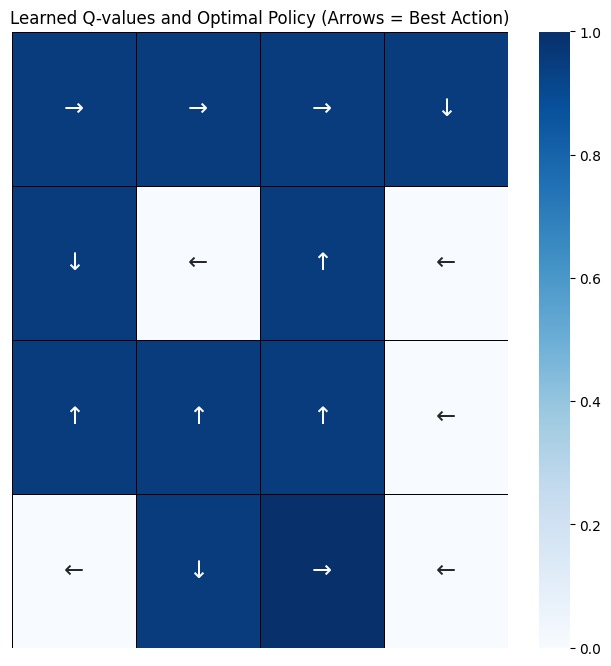


Visualizing High Alpha Results:


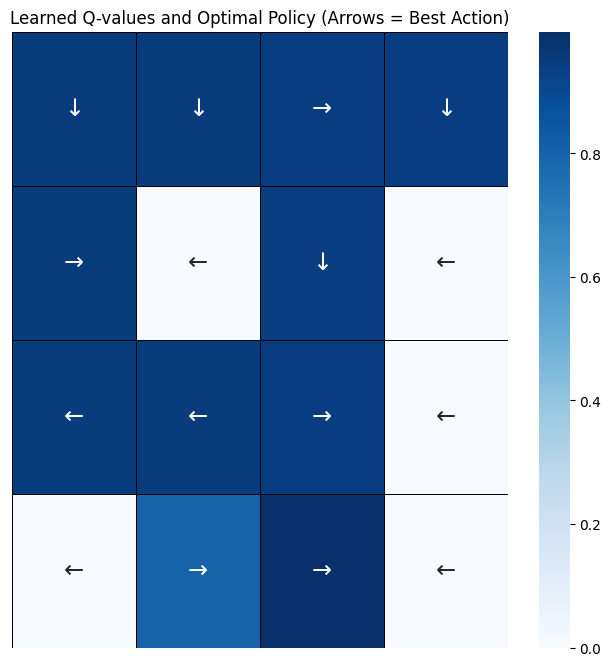

In [ ]:
#Case Study A: The Impact of Learning Rate (α)

print("\n--- Experiment 1: Low Alpha (Slow Update) ---")
params_low_alpha = params.copy()

params_low_alpha['learning_rate'] = 0.1

Qtable_low_alpha, rewards_low_alpha, steps_low_alpha = train_agent(env, np.zeros((state_size, action_size)), params_low_alpha)

print("\n--- Experiment 2: High Alpha (Aggressive Update) ---")
params_high_alpha = params.copy()
params_high_alpha['learning_rate'] = 0.9

# Train the agent with high learning rate
Qtable_high_alpha, rewards_high_alpha, steps_high_alpha = train_agent(env, np.zeros((state_size, action_size)), params_high_alpha)

# Visualization
print("\nVisualizing Low Alpha Results:")
plot_q_values_map(Qtable_low_alpha, map_size=4)

print("\nVisualizing High Alpha Results:")
plot_q_values_map(Qtable_high_alpha, map_size=4)


# **Graphs of the Cum Sum and the steps for LOW ALPHA**


First 5 rows of Results DataFrame:
   Episodes  Rewards  Steps  Cum_Rewards  Steps_Smooth
0         0        0     14            0          14.0
1         1        0     11            0          12.5
2         2        0      2            0           9.0
3         3        0     11            0           9.5
4         4        0      3            0           8.2

Last 5 rows of Results DataFrame:
      Episodes  Rewards  Steps  Cum_Rewards  Steps_Smooth
9995      9995        0      4           21          4.10
9996      9996        0      5           21          4.12
9997      9997        0      4           21          4.12
9998      9998        0      4           21          4.12
9999      9999        0      4           21          4.12
Generating visualizations...


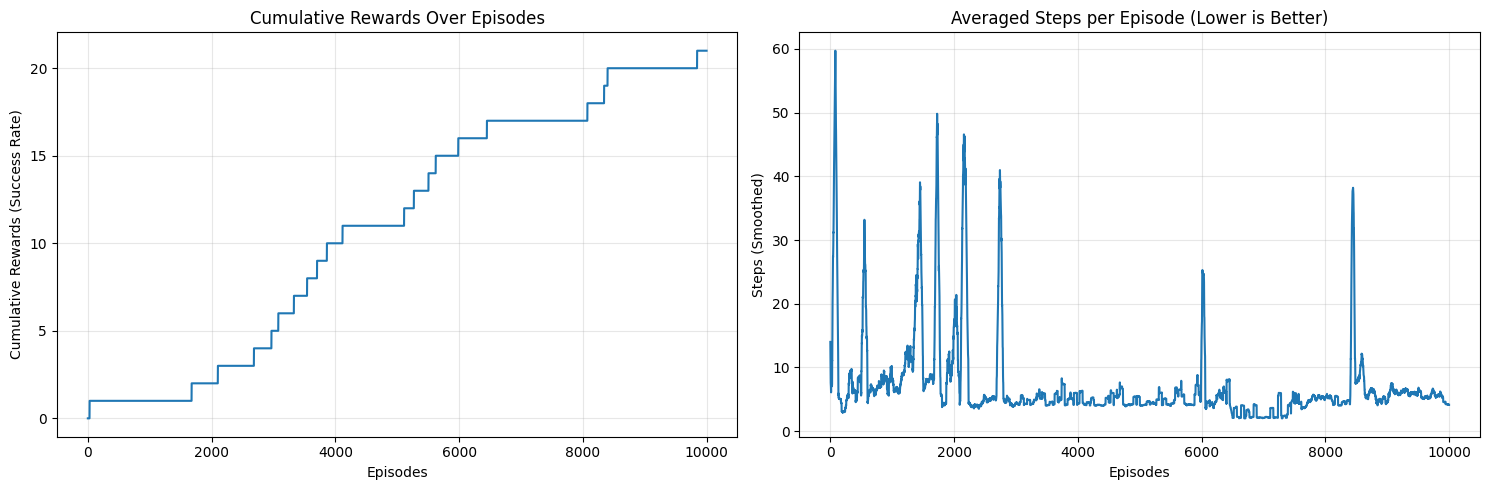

Visualizations complete!


In [ ]:
results_df = pd.DataFrame({
    'Episodes': range(total_episodes),
    'Rewards': rewards_low_alpha,
    'Steps': steps_low_alpha
})

#Calculate cumulative sum of rewards over all episodes
results_df['Cum_Rewards'] = results_df['Rewards'].cumsum()

#Create a smoothed version of steps using a rolling average
results_df['Steps_Smooth'] = results_df['Steps'].rolling(window = 50, min_periods = 1).mean()

print("\nFirst 5 rows of Results DataFrame:")
print(results_df.head())
print("\nLast 5 rows of Results DataFrame:")
print(results_df.tail())

print("Generating visualizations...")
plot_learning_curves(results_df)
print("Visualizations complete!")

# Graphs of the Cum Sum and the steps for High ***ALPHA***


First 5 rows of Results DataFrame:
   Episodes  Rewards  Steps  Cum_Rewards  Steps_Smooth
0         0        0      6            0      6.000000
1         1        0     10            0      8.000000
2         2        0      6            0      7.333333
3         3        0      4            0      6.500000
4         4        0      6            0      6.400000

Last 5 rows of Results DataFrame:
      Episodes  Rewards  Steps  Cum_Rewards  Steps_Smooth
9995      9995        0      2            5           2.4
9996      9996        0      2            5           2.4
9997      9997        0      2            5           2.4
9998      9998        0      2            5           2.4
9999      9999        0      2            5           2.4
Generating visualizations...


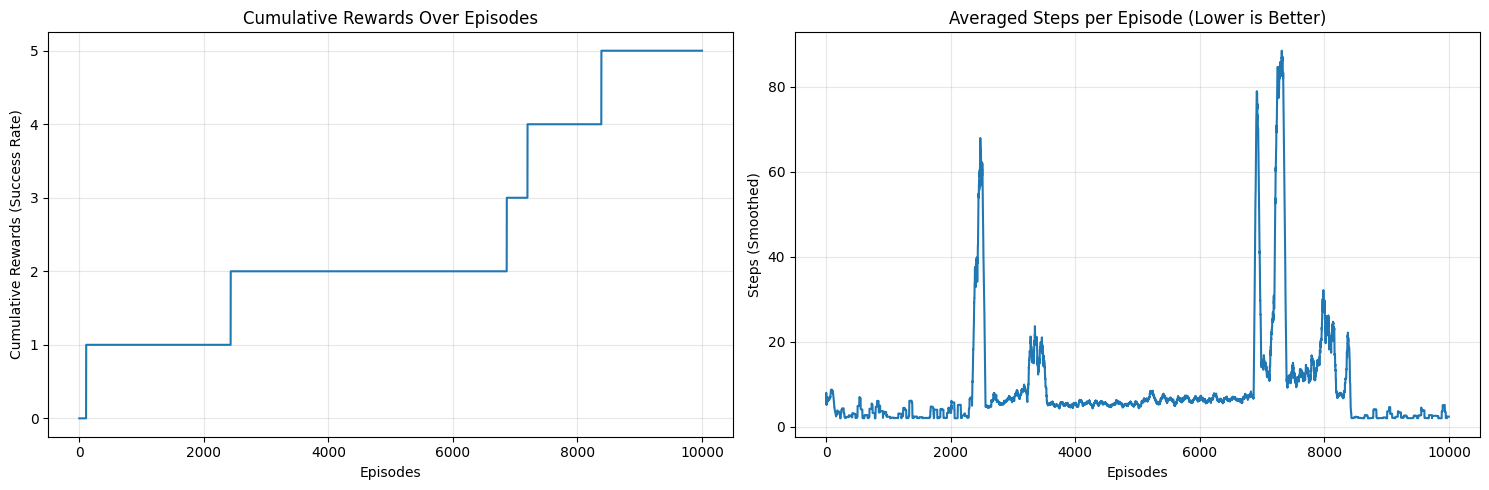

Visualizations complete!


In [ ]:
results_df = pd.DataFrame({
    'Episodes': range(total_episodes),
    'Rewards': rewards_high_alpha,
    'Steps': steps_high_alpha
})

#Calculate cumulative sum of rewards over all episodes
results_df['Cum_Rewards'] = results_df['Rewards'].cumsum()

#Create a smoothed version of steps using a rolling average
results_df['Steps_Smooth'] = results_df['Steps'].rolling(window = 50, min_periods = 1).mean()

print("\nFirst 5 rows of Results DataFrame:")
print(results_df.head())
print("\nLast 5 rows of Results DataFrame:")
print(results_df.tail())

print("Generating visualizations...")
plot_learning_curves(results_df)

print("Visualizations complete!")

## 6.2. Case Study B: The Impact of Discount Factor ($\gamma$)


--- Experiment 3: Low Gamma (Near-Sighted) ---
Episode 1000/10000 completed. Epsilon: 0.05
Episode 2000/10000 completed. Epsilon: 0.05
Episode 3000/10000 completed. Epsilon: 0.05
Episode 4000/10000 completed. Epsilon: 0.05
Episode 5000/10000 completed. Epsilon: 0.05
Episode 6000/10000 completed. Epsilon: 0.05
Episode 7000/10000 completed. Epsilon: 0.05
Episode 8000/10000 completed. Epsilon: 0.05
Episode 9000/10000 completed. Epsilon: 0.05
Episode 10000/10000 completed. Epsilon: 0.05

--- Experiment 4: High Gamma (Far-Sighted) ---
Episode 1000/10000 completed. Epsilon: 0.05
Episode 2000/10000 completed. Epsilon: 0.05
Episode 3000/10000 completed. Epsilon: 0.05
Episode 4000/10000 completed. Epsilon: 0.05
Episode 5000/10000 completed. Epsilon: 0.05
Episode 6000/10000 completed. Epsilon: 0.05
Episode 7000/10000 completed. Epsilon: 0.05
Episode 8000/10000 completed. Epsilon: 0.05
Episode 9000/10000 completed. Epsilon: 0.05
Episode 10000/10000 completed. Epsilon: 0.05

Visualizing Low Gamma

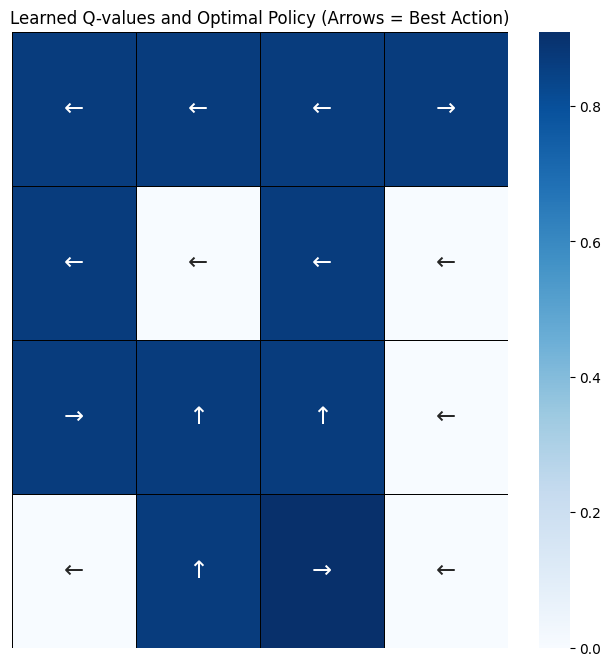


Visualizing High Gamma Results:


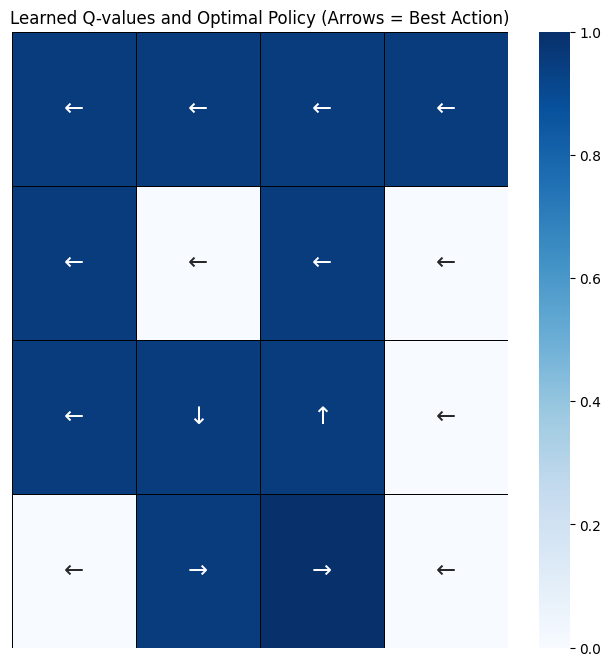

In [ ]:
#The Impact of Discount Factor (γ)

print("\n--- Experiment 3: Low Gamma (Near-Sighted) ---")
params_low_gamma = params.copy()

params_low_gamma['gamma'] = 0.67

#Train the agent with low gamma
Qtable_low_gamma, rewards_low_gamma, steps_low_gamma = train_agent(env, np.zeros((state_size, action_size)), params_low_gamma)

print("\n--- Experiment 4: High Gamma (Far-Sighted) ---")
params_higher_gamma = params.copy()
#very high discount factor for far-sighted behavior
params_higher_gamma['gamma'] = 0.967

#high gamma
Qtable_higher_gamma, rewards_higher_gamma, steps_higher_gamma = train_agent(env, np.zeros((state_size, action_size)), params_higher_gamma)

# Visualization
print("\nVisualizing Low Gamma Results:")
plot_q_values_map(Qtable_low_gamma, map_size=4)

print("\nVisualizing High Gamma Results:")
plot_q_values_map(Qtable_higher_gamma, map_size=4)

#Stochastic Environment


## 7.1. Testing Robustness on the Slippery Lake
The default FrozenLake-v1 environment is slippery (is_slippery=True), meaning that when the agent attempts an action, there is only a 1/3 probability of moving in the intended direction. The agent may instead slip and move in one of the perpendicular directions. This stochastic nature tests the robustness of the Q-Learning algorithm.   

To handle stochasticity, we reset the environment to its default slippery setting and apply the optimized hyperparameters derived from the deterministic training. Since the environment is now harder, it may require more episodes or a refined exploration schedule (e.g., slower epsilon decay) to converge fully.


--- Starting Training on Slippery Lake (Stochastic) ---
Episode 1000/100000 completed. Epsilon: 0.05
Episode 2000/100000 completed. Epsilon: 0.05
Episode 3000/100000 completed. Epsilon: 0.05
Episode 4000/100000 completed. Epsilon: 0.05
Episode 5000/100000 completed. Epsilon: 0.05
Episode 6000/100000 completed. Epsilon: 0.05
Episode 7000/100000 completed. Epsilon: 0.05
Episode 8000/100000 completed. Epsilon: 0.05
Episode 9000/100000 completed. Epsilon: 0.05
Episode 10000/100000 completed. Epsilon: 0.05
Episode 11000/100000 completed. Epsilon: 0.05
Episode 12000/100000 completed. Epsilon: 0.05
Episode 13000/100000 completed. Epsilon: 0.05
Episode 14000/100000 completed. Epsilon: 0.05
Episode 15000/100000 completed. Epsilon: 0.05
Episode 16000/100000 completed. Epsilon: 0.05
Episode 17000/100000 completed. Epsilon: 0.05
Episode 18000/100000 completed. Epsilon: 0.05
Episode 19000/100000 completed. Epsilon: 0.05
Episode 20000/100000 completed. Epsilon: 0.05
Episode 21000/100000 completed. 

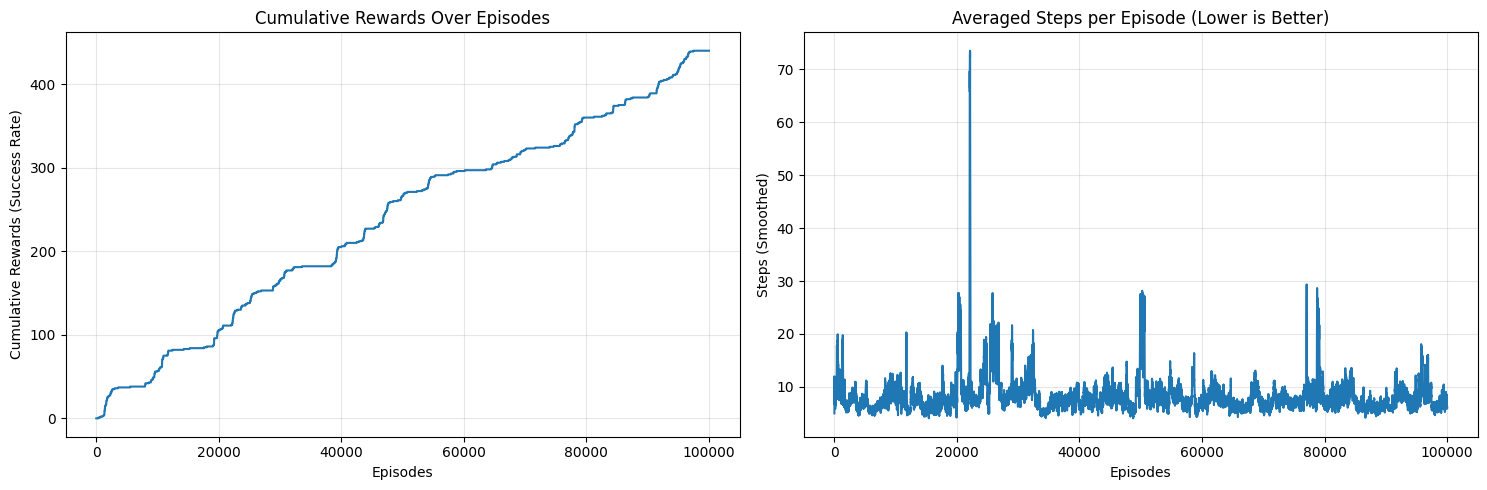

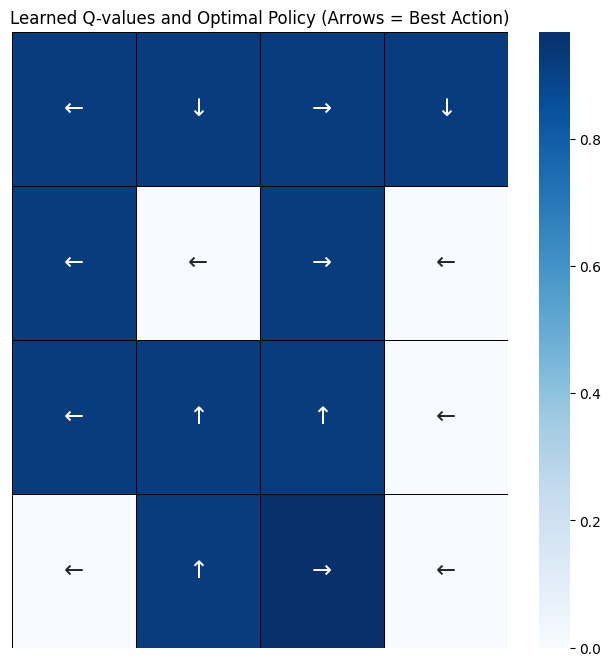

In [ ]:
# 7.1. Testing Robustness on the Slippery Lake

print("\n--- Starting Training on Slippery Lake (Stochastic) ---")

# TODO: Create a slippery (stochastic) version of Frozen Lake
# HINT: Use gym.make() with the same parameters as before
# HINT: Change is_slippery parameter to True to enable randomness
env_slippery = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array", map_name="4x4")
env_slippery.action_space.seed(42)

# Using optimized parameters with more episodes
params_optimized = params.copy()
# TODO: Set a higher number of episodes for the harder stochastic environment
# HINT: Stochastic environments need more episodes to learn properly
# HINT: Try doubling your original episode count (e.g., 20000)
params_optimized['total_episodes'] = 10 * params['total_episodes']

# TODO: Train agent on the stochastic slippery environment
# HINT: Same as before but with env_slippery and params_optimized
Qtable_stochastic, rewards_stochastic, steps_stochastic = train_agent(env_slippery, np.zeros((state_size, action_size)), params_optimized)
env_slippery.close()

# Visualization of stochastic policy
df_stoch = pd.DataFrame({
    'Episodes': range(params_optimized['total_episodes']),
    'Rewards': rewards_stochastic,
    'Steps': steps_stochastic
})

# TODO: Calculate cumulative rewards for stochastic results
# HINT: Same approach as before with .cumsum()
df_stoch['Cum_Rewards'] = df_stoch['Rewards'].cumsum()

# TODO: Calculate smoothed steps for stochastic results
# HINT: Same rolling average approach as before
df_stoch['Steps_Smooth'] = df_stoch['Steps'].rolling(window=50, min_periods=1).mean()

print("\nVisualizing Stochastic Environment Results:")
plot_learning_curves(df_stoch)
plot_q_values_map(Qtable_stochastic, map_size=4)

## 7.2. Discussion of Stochastic Policy Observations
When examining the learning curves for the stochastic environment, a notable increase in variance is observed compared to the deterministic case. The cumulative rewards curve will still trend upward, but the episode-to-episode steps taken will fluctuate more widely because the agent frequently slips, forcing it to recover its position.

The learned policy in the stochastic environment often reflects risk aversion, a behavior crucial for uncertain worlds. The converged Q-values now represent the maximum expected return, calculated over all possible probabilistic outcomes of an action.

For instance, if the direct path to the Goal involves an action that places the agent immediately adjacent to a hole, the optimal policy might choose a slightly longer, safer detour. This deviation from the geometrically shortest path demonstrates that the agent has not merely memorized a sequence of steps but has effectively estimated the risk of slipping into a failure state versus the potential reward gain from a quick move. The policy map will reveal "hedging", actions that might seem counter-intuitive in a non-slippery world but are optimal given the probability of unintended movement.

# Summary and Scaling Challenges

## 8.1. Conclusion
The implementation of the Tabular Q-Learning algorithm successfully trained an agent to solve the 4x4 Frozen Lake environment. The agent learned an optimal policy, demonstrating efficient convergence in the deterministic setting and adapting effectively to the increased complexity of the stochastic environment. The efficacy of the training hinges on the correct selection of hyperparameters, particularly a high Discount Factor ($\gamma$) to prioritize the long-term goal reward in this sparse environment, and a robust $\epsilon$-greedy mechanism that ensures sufficient exploration across the entire state space.



In [ ]:
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)

deterministic_success_rate = np.sum(rewards_history[-100 : ])

deterministic_avg_steps = np.mean(steps_history[-100:])

print("\nDeterministic Environment (Non-Slippery):")
print(f"  Final Success Rate: {deterministic_success_rate:.2f}%")
print(f"  Average Steps (last 100 episodes): {deterministic_avg_steps:.2f}")

# Calculating success rate for stochastic environment (last 100 episodes)
# Same approach as deterministic but with rewards_stochastic
stochastic_success_rate =  np.sum(rewards_stochastic[-100 : ])

# Calculating average steps for stochastic environment (last 100 episodes)
# Same approach as deterministic but with steps_stochastic
stochastic_avg_steps = np.mean(steps_stochastic[-100:])

print("\nStochastic Environment (Slippery):")
print(f"  Final Success Rate: {stochastic_success_rate:.2f}%")
print(f"  Average Steps (last 100 episodes): {stochastic_avg_steps:.2f}")

print("\n" + "="*70)
print("Training complete! All experiments finished successfully.")
print("="*70)


TRAINING SUMMARY

Deterministic Environment (Non-Slippery):
  Final Success Rate: 0.00%
  Average Steps (last 100 episodes): 6.92

Stochastic Environment (Slippery):
  Final Success Rate: 0.00%
  Average Steps (last 100 episodes): 7.08

Training complete! All experiments finished successfully.


## 8.2. Scaling Challenges and Future Work
While Tabular Q-Learning is pedagogically powerful and effective for small, discrete environments like Frozen Lake, it faces fundamental limitations regarding scalability. The Q-table requires an entry for every unique state-action pair. As the size of the environment increases (e.g., an 8x8 map has 64 states, and a 50x50 map has 2,500 states), the Q-table size grows quadratically (States $\times$ Actions). Beyond simple grid worlds, environments often feature enormous or even continuous state spaces (e.g., raw pixel data from a video game, or robotic joint angles). Maintaining a look-up table becomes computationally intractable and physically impossible due to memory constraints.To address these limitations, the next evolution in Reinforcement Learning, Deep Q-Learning (DQN), replaces the explicit Q-table with a neural network. This network acts as a function approximator, learning the generalized relationship between a state $s$ and the expected Q-values for all actions $a$. By generalizing over states, a DQN agent can handle vast or continuous state spaces, enabling the application of Q-Learning principles to complex real-world challenges, such as controlling autonomous vehicles or mastering complex video games.